# ToastMetrics — Analyst Report (Quick Visuals)

This notebook loads ToastMetrics data from the SQLite database (created by `toastmetrics_app.py`) and generates three recruiter-friendly charts:

1. **Quantity vs Net Sales (scatter)** — highlights high-volume vs high-revenue items  
2. **Net Sales by Sales Category (bar)** — where revenue is coming from  
3. **Bottom 10 Food Items by Quantity (barh)** — underperformers for menu review

> Tip: Run `toastmetrics_app.py` first so the `sales` table is up to date.


In [1]:
from pathlib import Path
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# --- Configure paths ---
# Option A: DB at repo root
DB_CANDIDATES = [
    Path("toastmetrics.db"),
    Path("Projects") / "ToastMetrics" / "toastmetrics.db",
]

db_path = next((p for p in DB_CANDIDATES if p.exists()), None)

if db_path is None:
    raise FileNotFoundError(
        "Could not find toastmetrics.db. Update DB_CANDIDATES to point to your database file."
    )

db_path


WindowsPath('toastmetrics.db')

In [2]:
# --- Load data from SQLite ---
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM sales", conn)
conn.close()

df.head(), df.shape


(  Sales Category              Item Name Modifier  Avg Price    Quantity  \
 0           Food           Dessert Trio     None  26.000000    6.000000   
 1           Food   Classic Caesar Salad     None  15.607143   80.000000   
 2           Food  Chitarra Cacio e Pepe     None  30.914449  121.999998   
 3           Food       Red wine special     None   0.000000    1.000000   
 4           Food               Tiramisu     None  20.461538   71.000000   
 
    Gross Sales  Discount Amount  Net Sales                          Week  
 0       156.00              0.0     156.00  menu-breakdown-dec-8-14-2025  
 1      1220.00             15.0    1205.00  menu-breakdown-dec-8-14-2025  
 2      3847.98             28.0    3819.98  menu-breakdown-dec-8-14-2025  
 3         0.00              0.0       0.00  menu-breakdown-dec-8-14-2025  
 4       962.00            294.0     668.00  menu-breakdown-dec-8-14-2025  ,
 (246, 9))

In [3]:
# --- Basic sanity checks ---
required_cols = ["Item Name", "Quantity", "Net Sales"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Coerce types (safe even if already numeric)
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["Net Sales"] = pd.to_numeric(df["Net Sales"], errors="coerce")

# Drop rows that can't be plotted
plot_df = df.dropna(subset=["Quantity", "Net Sales"]).copy()

# Optional: remove totals/summary rows if they sneak in
plot_df = plot_df[~plot_df["Item Name"].str.contains("total", case=False, na=False)]

plot_df.shape


(246, 9)

## 1) Quantity vs Net Sales (Scatter)

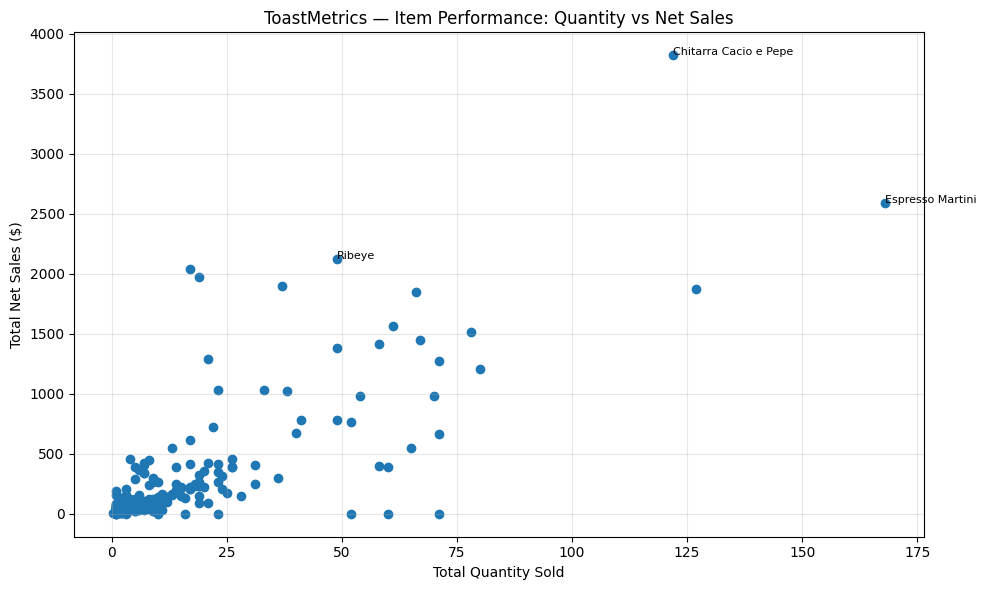

,Item Name,Quantity,Net Sales
78,Chitarra Cacio e Pepe,121.999998,3819.98
97,Espresso Martini,168.000000,2592.00
207,Ribeye,49.000000,2119.00
164,MAGNIFICO $120 FAMILY STYLE ENTREE,17.000000,2040.00
114,GUSTOSO $104,19.000000,1976.00
102,Filet Mignon,37.000000,1900.00
166,MARTINI,127.000000,1876.00
232,Tagliolini al Limone,66.000000,1847.50
205,Ravioli del Salumiere,61.000000,1563.00
231,Tagliatelle Bolognese,78.000000,1515.00


In [ ]:
# Aggregate to item-level totals
item_totals = (
    plot_df.groupby("Item Name", as_index=False)[["Quantity", "Net Sales"]]
    .sum()
)

plt.figure(figsize=(10, 6))
plt.scatter(item_totals["Quantity"], item_totals["Net Sales"])
plt.title("ToastMetrics — Item Performance: Quantity vs Net Sales")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Total Net Sales ($)")
plt.grid(True, alpha=0.3)

# Label top 3 revenue items only
top_items = item_totals.sort_values("Net Sales", ascending=False).head(3)

for _, row in top_items.iterrows():
    plt.annotate(
        row["Item Name"],
        (row["Quantity"], row["Net Sales"]),
        fontsize=8
    )
plt.tight_layout()
plt.show()

item_totals.sort_values("Net Sales", ascending=False).head(10)


## 2) Net Sales by Sales Category (Bar)

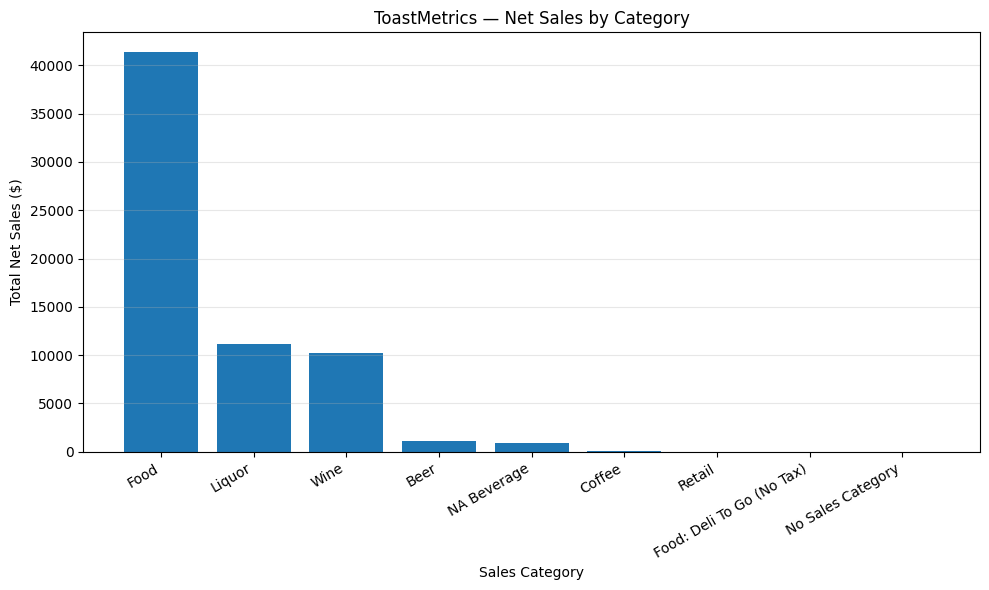

In [5]:
if "Sales Category" in plot_df.columns:
    cat_sales = (
        plot_df.groupby("Sales Category", as_index=False)["Net Sales"]
        .sum()
        .sort_values("Net Sales", ascending=False)
    )

    plt.figure(figsize=(10, 6))
    plt.bar(cat_sales["Sales Category"], cat_sales["Net Sales"])
    plt.title("ToastMetrics — Net Sales by Category")
    plt.xlabel("Sales Category")
    plt.ylabel("Total Net Sales ($)")
    plt.xticks(rotation=30, ha="right")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    cat_sales
else:
    print("No 'Sales Category' column found in this dataset.")


## 3) Bottom 10 Food Items by Quantity (Barh)

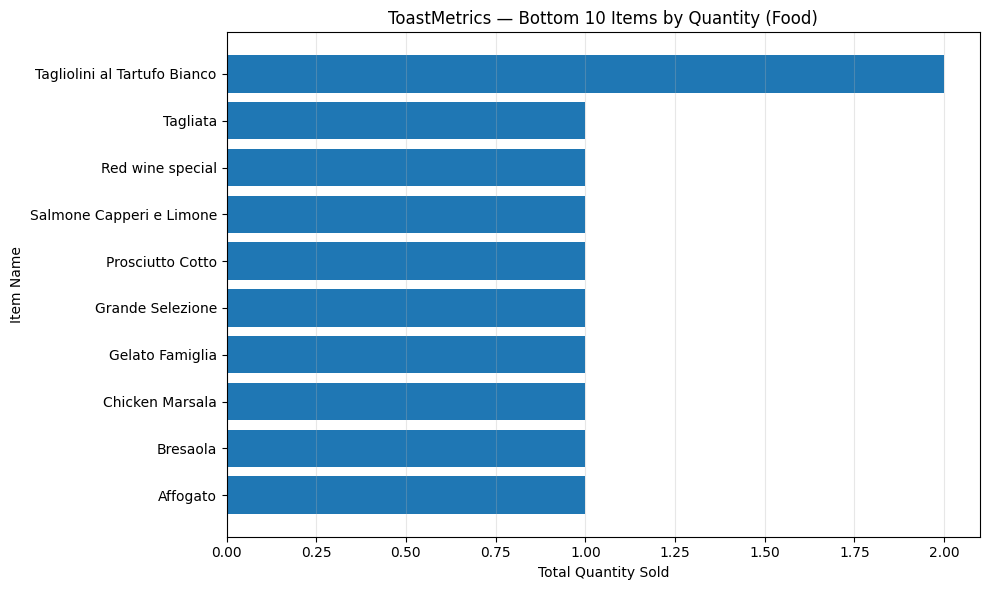

,Item Name,Quantity
1,Affogato,1.0
6,Bresaola,1.0
15,Chicken Marsala,1.0
32,Gelato Famiglia,1.0
35,Grande Selezione,1.0
62,Prosciutto Cotto,1.0
72,Salmone Capperi e Limone,1.0
66,Red wine special,1.0
78,Tagliata,1.0
81,Tagliolini al Tartufo Bianco,2.0


In [6]:
# If category exists, focus on Food; otherwise, show overall bottom 10
data_for_bottom = plot_df.copy()

if "Sales Category" in data_for_bottom.columns:
    food_df = data_for_bottom[data_for_bottom["Sales Category"].astype(str).str.lower() == "food"]
    if len(food_df) > 0:
        data_for_bottom = food_df

bottom10 = (
    data_for_bottom.groupby("Item Name", as_index=False)["Quantity"]
    .sum()
    .sort_values("Quantity", ascending=True)
    .head(10)
)

plt.figure(figsize=(10, 6))
plt.barh(bottom10["Item Name"], bottom10["Quantity"])
plt.title("ToastMetrics — Bottom 10 Items by Quantity" + (" (Food)" if "Sales Category" in plot_df.columns else ""))
plt.xlabel("Total Quantity Sold")
plt.ylabel("Item Name")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

bottom10


## Key Observations

- Revenue concentration: A small set of items drives a disproportionate share of net sales (e.g., Chitarra Cacio e Pepe sits at the top of the revenue distribution).
- High-volume ≠ top revenue: Some items sell in very high quantities (e.g., Espresso Martini) but do not lead revenue, suggesting opportunities to evaluate pricing, add-ons, or upsell strategy.
- Mid-tier opportunity set: Several items cluster in a “steady performer” band (moderate quantity, moderate net sales), which could be targeted for promotion to shift them into higher-revenue territory.